# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [3]:
#Preprocesamiento y manipulacion de data
import numpy as np
import pandas as pd

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Entrenamiento, GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Modelo estadistico
from statsmodels.tsa.seasonal import seasonal_decompose

#Separacion de series temporales
from sklearn.model_selection import TimeSeriesSplit

#Crear pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 

#Metricas de calidad
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

#Modelos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor 

In [5]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
# Valores ausentes
df.isna().sum()

num_orders    0
dtype: int64

In [9]:
# Estan en orden cronologico?
df.index.is_monotonic

True

In [10]:
#Primer índice
print("Primer índice", df.index.min())

#Último índice
print("Último índice", df.index.max())

Primer índice 2018-03-01 00:00:00
Último índice 2018-08-31 23:50:00


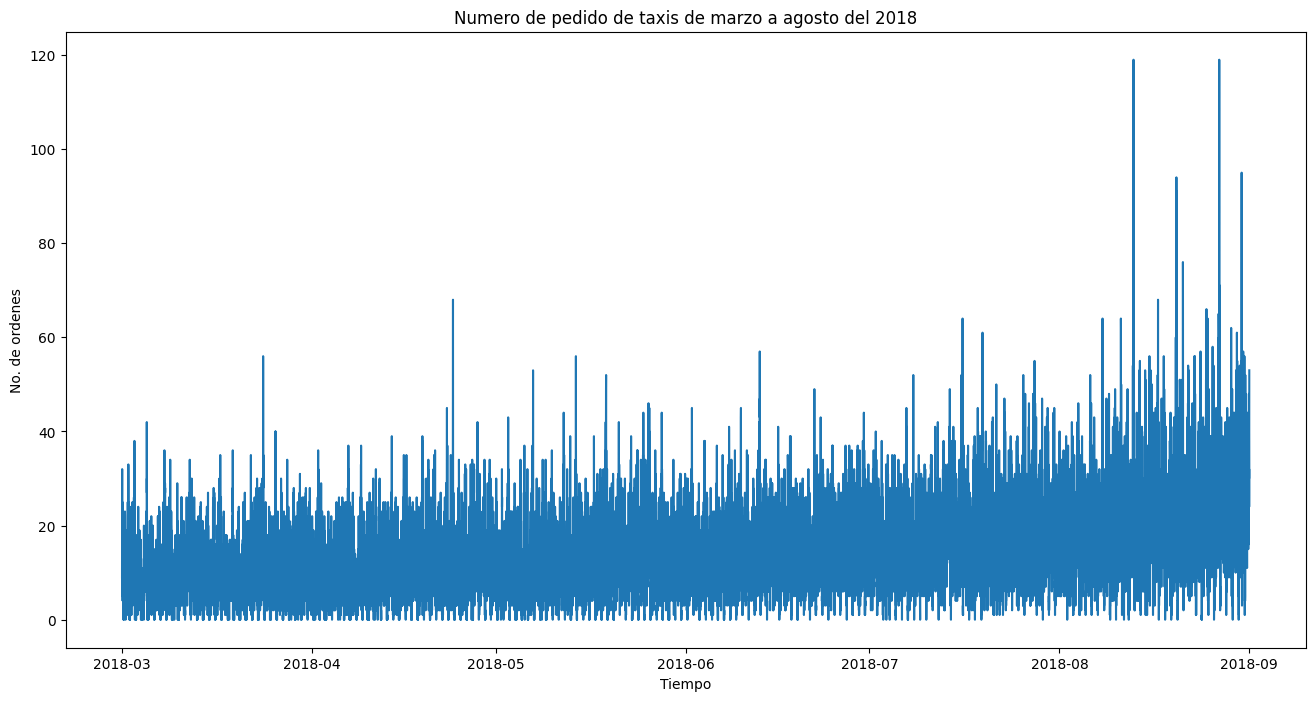

In [11]:
#Visualizacion
ts = df['num_orders']
plt.figure(figsize=(16,8))
plt.title('Numero de pedido de taxis de marzo a agosto del 2018')
plt.xlabel('Tiempo')
plt.ylabel('No. de ordenes')
plt.plot(ts);

## Análisis

In [12]:
# Agrupar la data en intervalos de una hora
ts = ts.resample('1H').sum()

In [13]:
ts.head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: int64

<AxesSubplot:title={'center':'Grafica del 1 al 14 de marzo'}, xlabel='datetime'>

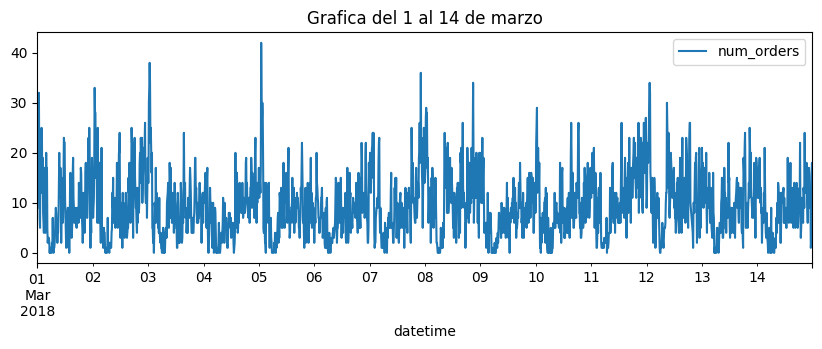

In [14]:
# Grafica de la data del 1 al 14 de marzo
dataWeek = df['2018-03-01':'2018-03-14']
dataWeek.plot(figsize=(10,3),title='Grafica del 1 al 14 de marzo')

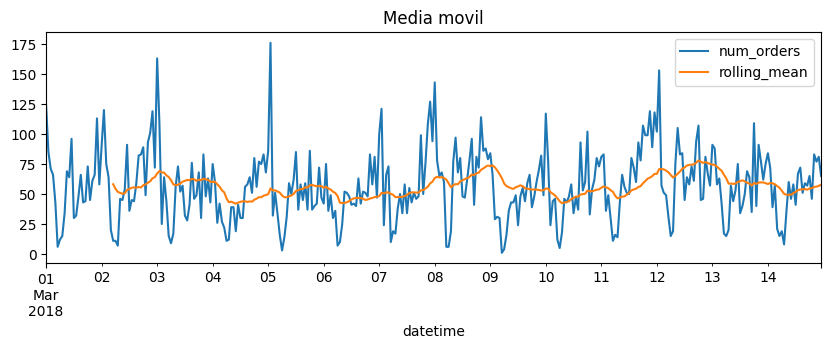

In [12]:
dataWeek = dataWeek.resample('1H').sum()
dataWeek['rolling_mean'] = dataWeek.rolling(30).mean() 
dataWeek.plot(figsize=(10,3),title='Media movil');

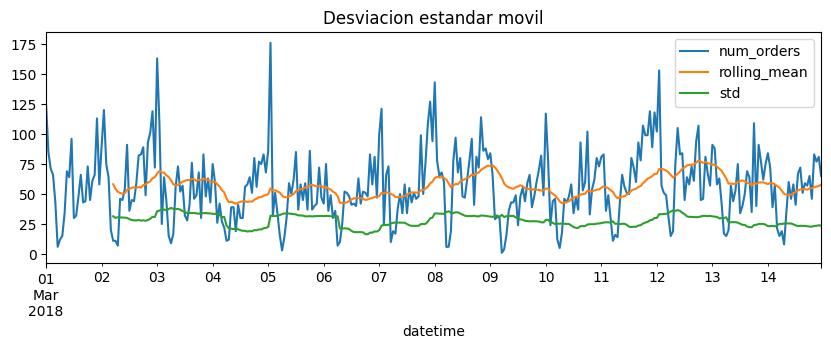

In [13]:
dataWeek['std'] = dataWeek['num_orders'].rolling(30).std() 
dataWeek.plot(figsize=(10,3),title='Desviacion estandar movil');

Text(0.5, 1.0, 'Tendencia')

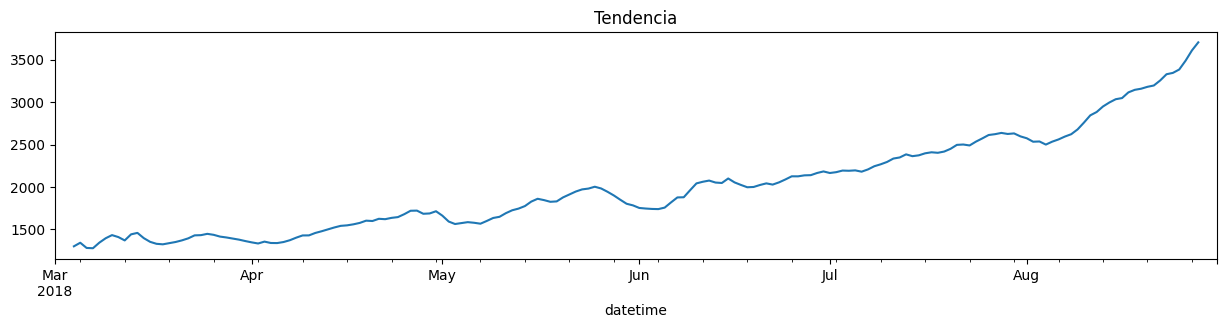

In [14]:
#Tendencia
ts_ = ts.resample('1D').sum()

decompose = seasonal_decompose(ts_)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Tendencia')

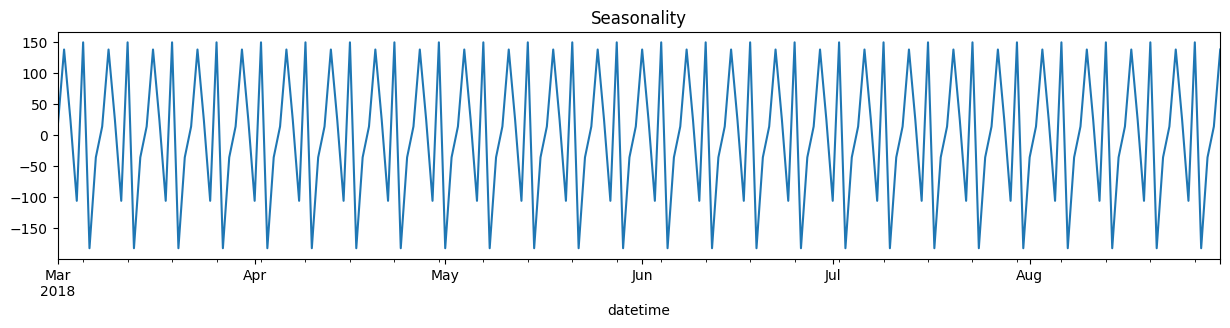

In [15]:
#Estacionalidad
plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality');

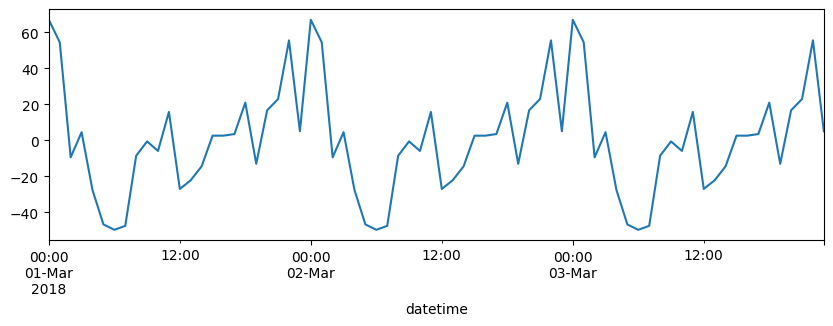

In [16]:
#Estacionalidad por hora de 3 dias
tmp = dataWeek['2018-03-01':'2018-03-03']

decomposed_hour = seasonal_decompose(tmp['num_orders'])

decomposed_hour.seasonal.plot(ax=plt.gca(), figsize=(10,3));

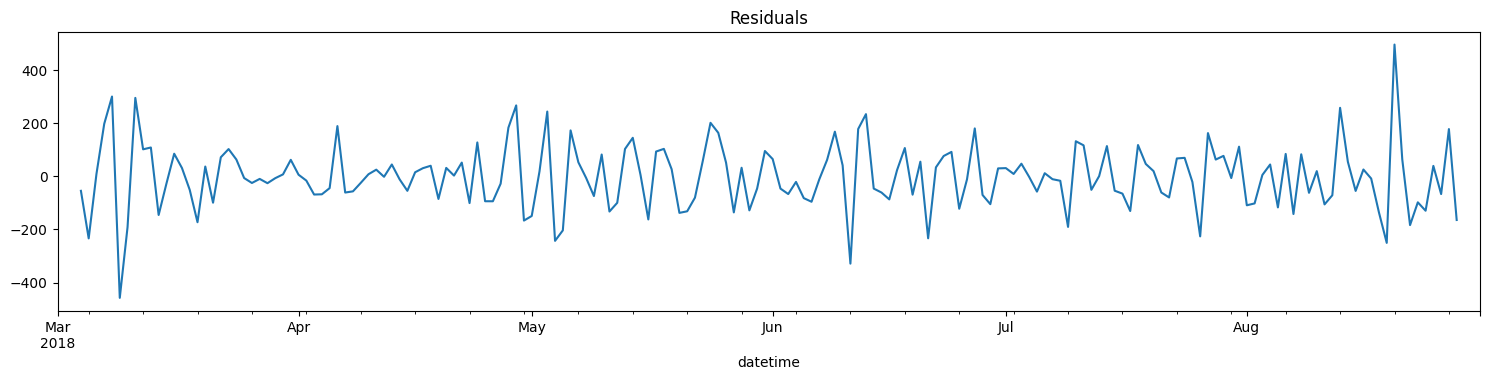

In [17]:
#Residuales
plt.subplot(313)
decompose.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')
plt.tight_layout()

## Formación

In [16]:
# funcion para crear nuevos features
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
# Crear nuevos features
ts = pd.DataFrame(ts)
make_features(ts,5,6)

In [18]:
ts.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN


In [19]:
# Eliminar los valores nulo
ts = ts.dropna()

In [20]:
ts.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,65.833333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,47.166667
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,35.500000
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,29.333333
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,29.833333


In [21]:
# Entrenamiento de modelo
train, test = train_test_split(ts, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [22]:
# Separar en series temporales
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
# Crear pipelines
pipe_rfr = Pipeline([('scaler1', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100))])

pipe_linear = Pipeline([('scaler2', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])

pipe_cat_boost_r = Pipeline([('scaler3', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(verbose=500))])

pipe_lgbm_r =  Pipeline([('scaler4', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor())])

pipe_xgb_r = Pipeline([('scaler5', StandardScaler()),
                       ('XGBRegressor', XGBRegressor())])
pipe_neighbors = Pipeline([('scaler6',StandardScaler()),('KNeighborsRegressor',KNeighborsRegressor())])

In [24]:
#Lista de pipelines
pipelines = [pipe_rfr, pipe_linear, pipe_cat_boost_r, pipe_lgbm_r, pipe_xgb_r,pipe_neighbors]

In [25]:
#Diccionario de pipelines
pipe_dict = {pipe_rfr:'RandomForestRegressor', pipe_linear:'LinearRegression',\
             pipe_cat_boost_r: 'CatBoostRegressor', pipe_lgbm_r: 'LGBMRegressor', pipe_xgb_r:'XGBRegressor',pipe_neighbors:'KNeighborsRegressor'}

In [26]:
%%time
#Cross validation de las series temporales y regresa el puntaje cada split
for pipeline in pipelines:
    print(pipe_dict[pipeline])
    print(cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv))
    print()

RandomForestRegressor
[-22.87976555 -22.94939724 -23.85668766 -25.09406616 -31.65070259]

LinearRegression
[-26.98649825 -28.92730832 -30.36028408 -31.9644769  -39.43353003]

CatBoostRegressor
Learning rate set to 0.038378
0:	learn: 29.0777351	total: 47ms	remaining: 47s
500:	learn: 8.9081647	total: 837ms	remaining: 834ms
999:	learn: 4.8622108	total: 1.63s	remaining: 0us
Learning rate set to 0.042805
0:	learn: 29.9042672	total: 779us	remaining: 779ms
500:	learn: 11.1434086	total: 862ms	remaining: 859ms
999:	learn: 7.3334837	total: 1.75s	remaining: 0us
Learning rate set to 0.045631
0:	learn: 31.3426433	total: 935us	remaining: 934ms
500:	learn: 12.7561277	total: 874ms	remaining: 871ms
999:	learn: 9.3884000	total: 1.87s	remaining: 0us
Learning rate set to 0.04775
0:	learn: 32.6741683	total: 939us	remaining: 939ms
500:	learn: 14.0771008	total: 1s	remaining: 998ms
999:	learn: 10.5902657	total: 2.16s	remaining: 0us
Learning rate set to 0.049462
0:	learn: 33.9744517	total: 951us	remaining: 950

In [29]:
%%time
# Regresion lineal
model = LinearRegression()
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print("MAE para el set de entranmiento:", mean_absolute_error(predictions_train, y_train))
print("MAE para el set de pruebas: ", mean_absolute_error(predictions_test, y_test))
print('RMSE del modelo del set de entrenamiento:', mean_squared_error(predictions_train, y_train,squared=False))
print('RMSE del modelo del set de pruebas:', mean_squared_error(predictions_test, y_test,squared=False))

MAE para el set de entranmiento: 23.413461845173998
MAE para el set de pruebas:  40.34909239478184
RMSE del modelo del set de entrenamiento: 30.466809527160358
RMSE del modelo del set de pruebas: 53.11273335056838
CPU times: user 0 ns, sys: 24 ms, total: 24 ms
Wall time: 7.37 ms


In [30]:
%%time
# Random Forest
random_forest_param = {'n_estimators': (10, 25, 50, 100),
                       'max_depth': (None, 2, 4, 8, 10, 12),
                      }
RF_grid = GridSearchCV(RandomForestRegressor(random_state=0, criterion='mse'), param_grid=random_forest_param, 
                       cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
RF_grid_model = RF_grid.fit(X_train, y_train)
print(RF_grid_model.best_estimator_)
print()
print(RF_grid_model.best_score_)

RandomForestRegressor(random_state=0)

-25.340004554354724
CPU times: user 1.71 s, sys: 103 ms, total: 1.81 s
Wall time: 16.7 s


In [31]:
print('Los mejores hiperparametros son: {}'.format(RF_grid_model.best_params_))

Los mejores hiperparametros son: {'max_depth': None, 'n_estimators': 100}


In [ ]:
%%time
# XGBRegressor
xgb_param = {'learning_rate': (0.01, 0.1, 0.3),
              'n_estimators': (25, 50, 100),
              'base_score': (0.25, 0.5, 0.75)
              } 

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

XGB_grid = GridSearchCV(
    xgb,
    param_grid=xgb_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

XGB_grid_model = XGB_grid.fit(X_train, y_train)

print(XGB_grid_model.best_estimator_)
print(XGB_grid_model.best_score_)

In [33]:
print('Los mejores hiperparametros son: {}'.format(XGB_grid_model.best_params_))

NameError: name 'XGB_grid_model' is not defined

In [35]:
%%time
# LGBMRegressor
lgbm_param = {'learning_rate': (0.001, 0.01, 0.05, 0.1),
              'n_estimators': (50, 100,200,500),
             'num_leaves': [5, 10, 20, 31]
             } 

LGBM_grid = GridSearchCV(LGBMRegressor(), param_grid=lgbm_param, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1) 
LGBM_grid_model = LGBM_grid.fit(X_train, y_train)
print(LGBM_grid_model.best_estimator_)
print()
print(LGBM_grid_model.best_score_)

LGBMRegressor(learning_rate=0.05)

-25.13326300135325
CPU times: user 3min 18s, sys: 1.44 s, total: 3min 19s
Wall time: 1min 39s


In [ ]:
print('Los mejores hiperparametros son: {}'.format(LGBM_grid_model.best_params_))

In [33]:
%%time
# KNearest Neighbors
knn_param = {'n_neighbors' : range(1,5,1),
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_param, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=1) 
knn_grid_model = knn_grid.fit(X_train, y_train)
print(knn_grid_model.best_estimator_)
print()
print(knn_grid_model.best_score_)

KNeighborsRegressor(n_neighbors=4)

-34.26751909411264
CPU times: user 1.24 s, sys: 1.99 s, total: 3.23 s
Wall time: 1.88 s


In [34]:
print('Los mejores hiperparametros so: {}'.format(knn_grid_model.best_params_))

Los mejores hiperparametros so: {'algorithm': 'auto', 'n_neighbors': 4}


Conclusion: Varios algoritmos con distintos hiperparametros fueron entrenados. La metrica usada para evaluar los modelos es RSME. El algoritmo KNeighbors es el mas rapido pero tiene el peor RMSE. El regresor LightGBM  tuve el mejor RMSE (25.13) y es el modelo a escoger para la prueba.

## Conclusiones generales del proyecto

- Nivel general: en conjunto, el flujo completo está presente (preprocesamiento, EDA, features, validación temporal, búsquedas de hiperparámetros y evaluación), con buen manejo de herramientas y modelos. 📈🚀  
- Fortalezas:  
  - Buen EDA visual que muestra tendencia estacional y picos (gráficas claras). ✅  
  - Uso correcto de TimeSeriesSplit y pipelines, y experimentación con varios algoritmos (RF, LGBM, CatBoost, XGB, KNN). ✅  
  - Lograste un RMSE final en prueba por debajo del umbral (≈43.6), que cumple el objetivo. 🎯  
- Áreas de oportunidad y de mejora:  
  - Consistencia en el pipeline final: reentrena el modelo final con los hiperparámetros óptimos reportados en GridSearch antes de evaluar en el test (ahora hay discrepancia entre mejores parámetros y los usados en la prueba). 🔁  
  - Evitar fugas de información: al calcular medias móviles para features asegúrate de usar shift() antes del rolling (como hiciste luego en la función make_features) y documenta decisiones de agregación (sum vs median) porque afectan la escala del target. 🔒  
  - Robustez y reproducibilidad: revisa la ejecución completa de las celdas (corrige el NameError de XGB), añade semilla fija donde sea relevante y comenta/deja constancia de la lógica de elección de métricas y parámetros. 🧾  
- **Mensaje final:** Vas muy bien. El pipeline está armado y obtuviste un resultado que cumple el objetivo. Siempre ten cuidado en la parte de la búsqueda de hiperparámetros y reentrenamiento final, y conviene darle un ojo a las fugas de información y documentar las decisiones. Con esos ajustes el trabajo pasará a un nivel aún más profesional. ¡Sigue así! 💪✨

## Prueba

In [29]:
# Dummy de regresion lineal
dummy_test_model = Pipeline([('scaler0', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])
dummy_test_model.fit(X_train, y_train)
dummy_predictions_test = dummy_test_model.predict(X_test)
print('RMSE para el set de prueba:', mean_squared_error(y_test, dummy_predictions_test, squared=False))

RMSE para el set de prueba: 53.1127333505684


In [32]:

# LGBM
lgbm_test_model = Pipeline([('scaler2', StandardScaler()),
        ('LGBMRegressor', LGBMRegressor(learning_rate= 0.1, n_estimators= 200, num_leaves= 10))])
lgbm_test_model.fit(X_train, y_train)
lgbm_predictions_test = lgbm_test_model.predict(X_test)
print('RMSE para el set de prueba:', mean_squared_error(lgbm_predictions_test, y_test,squared=False))


RMSE para el set de prueba: 43.550944232656306


El modelo con mejor RMSE fue seleccionado par la prueba. Usando LightGBM obtenemos un RMSE de 43.55